In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib 
matplotlib.rcParams.update({'font.size': 15})
from collections import defaultdict
import pandas as pd

# Inputs

In [2]:
climate_data = pd.read_csv('ClimateData.csv')
climate_scenario = ['Dry', 'Wet'] #Kenya and UK

In [3]:
P_kenya = list(climate_data['P'].loc[(climate_data['Country'] == 'Kenya') & 
                          (climate_data['Cond'] == climate_scenario[0])])

P_uk = list(climate_data['P'].loc[(climate_data['Country'] == 'UK') & 
                          (climate_data['Cond'] == climate_scenario[1])])

# P_kenya = [x / sum(P_kenya) for x in P_kenya]
# P_uk = [x / sum(P_uk) for x in P_uk]

In [15]:
rH_b_K = 0.3
rG_b_K = 0.6

rH_m_K = 0.3
rG_m_K = 0.4

rH_o_K = 0.3
rG_o_K = 0.4

rH_c_K = 0.3
rG_c_K = 0.4

rH_B = 0.3
rG_B = 0.6
IN = 1

L_b = 0.1
L_m = 0.1
L_o = 0.1
L_c = 0.1

Delta_b_B = 50
Delta_b_K = 5
Delta_m = 6
Delta_o = 3
Delta_c = 4

A = 10
Omega = 2 * np.pi / 365
ET_B = 10
ET_K = 5
V = 10
Phi = np.pi

dt = 0.1
T = 5 * 365

first_season = [4, 5, 6]
second_season = [7, 8, 9]
third_season = [10, 11, 12]

c_drip = 10. #drip installment cost per operation length#

prob_local = 0.5

# Sample scenario

In [16]:
## Farmers decision
sign_contract = True
invest_drip = True
cult_third = False
beans_maize = True

## KHE decesion
price_KHE = 0.1 #Offerd price#
buy_bean = True
cult_month = 7
############
KHE_season = [(i + cult_month)%12 if (i + cult_month)%12  > 0 else 12 for i in range(3)]

# Simulation

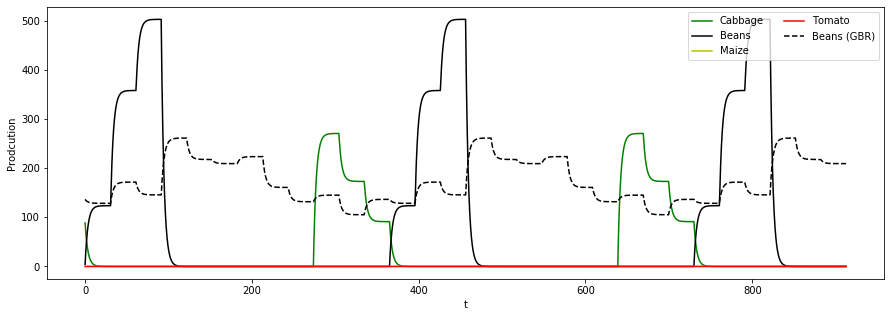

<Figure size 1080x360 with 0 Axes>

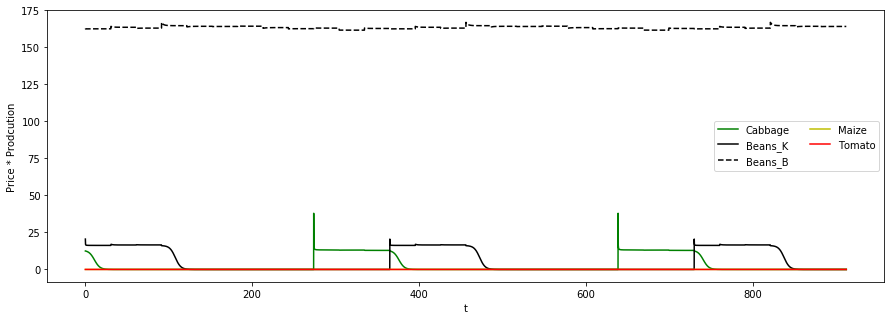

Farmers:  4755.123629448443
KHE:  42805.112665035995


In [17]:
Ni = int(T/dt)
Ty = 365
Tm = 365/12
Ny = int(Ty/dt)


b_K = np.zeros(Ni)
m_K = np.zeros(Ni)
o_K = np.zeros(Ni)
c_K = np.zeros(Ni)

W_K = np.zeros(Ni)
W_K[0] == 100
b_B = np.zeros(Ni)
W_B = np.zeros(Ni)
W_B[0] == 100
a = np.zeros(Ni)
a[0] == 1

A_b_K = np.zeros(Ni)
A_m_K = np.zeros(Ni)
A_o_K = np.zeros(Ni)
A_c_K = np.zeros(Ni)

S_b_B = np.zeros(Ni)
S_b_K = np.zeros(Ni)
S_m_K = np.zeros(Ni)
S_o_K = np.zeros(Ni)
S_c_K = np.zeros(Ni)

t = 0

for i in range(0, Ni - 1):
    
    t += dt
    
    month = min(int(t%Ty/Tm) + 1, 12)
    
    ## Cultivation decision
    if sign_contract:
        if month in KHE_season:
            A_b_K[i] = 1.
            A_m_K[i] = 0.
    elif beans_maize:
        if month in second_season:
            A_b_K[i] = 1.
            A_m_K[i] = 0.
    else:
        if month in second_season:
            A_b_K[i] = 0.
            A_m_K[i] = 1.
        
    if invest_drip and cult_third:
        if month in third_season:
            A_o_K[i] = 1.
        else:
            A_o_K[i] = 0.
            
    if  month in first_season:
        A_c_K[i] = 1.    
    
    #############################################################################
    b_B[i + 1 ] = b_B[i] + dt * (rG_B * W_B[i] -  rH_B * b_B[i])
#     W_B[i + 1 ] = W_B[i] + dt * (A * np.sin(Omega * t) - ET_B * W_B[i] + V)
    W_B[i + 1 ] = W_B[i] + dt * (A * P_uk[month - 1] - ET_B * W_B[i] + V)

    #############################################################################
#     W_K[i + 1 ] = W_K[i] + dt * (A * np.sin(Omega * t + Phi) - ET_K * W_K[i] + V)
    W_K[i + 1 ] = W_K[i] + dt * (A * P_kenya[month - 1] - ET_K * W_K[i] + V)

    
    b_K[i + 1 ] = b_K[i] + dt * (rG_b_K * A_b_K[i] * W_K[i] - rH_b_K * b_K[i])
    m_K[i + 1 ] = m_K[i] + dt * (rG_m_K * A_m_K[i] * W_K[i] - rH_m_K * m_K[i])
    o_K[i + 1 ] = o_K[i] + dt * (rG_o_K * A_o_K[i] * W_K[i] - rH_o_K * o_K[i])
    c_K[i + 1 ] = c_K[i] + dt * (rG_c_K * A_c_K[i] * W_K[i] - rH_c_K * c_K[i])
    
    ##############################################################################
    S_b_B[i + 1] = Delta_b_B / (IN + rH_B * b_B[i])
    S_b_K[i + 1] = Delta_b_K / (1 + rH_b_K * b_K[i])
    S_m_K[i + 1] = Delta_m / (1 + rH_m_K * m_K[i])
    S_o_K[i + 1] = Delta_o / (1 + rH_o_K * o_K[i])
    S_c_K[i + 1] = Delta_c / (1 + rH_c_K * c_K[i])


F_gain = 0.
if sign_contract:
    if buy_bean:
        ## Selling to KHE
        F_gain += (rH_b_K * b_K[Ty:] * S_b_B[Ty:]).sum() * price_KHE
    else:
        ## selling to local distributor 
        F_gain += (rH_b_K * b_K[Ty:] * np.heaviside(S_b_K[Ty:] - L_b, 0)).sum() * prob_local   
else:
    F_gain += (rH_b_K * b_K[Ty:] * np.heaviside(S_b_K[Ty:] - L_b, 0)).sum()

F_gain += (rH_m_K * m_K[Ty:] * np.heaviside(S_m_K[Ty:] - L_m, 0)).sum()
F_gain += (rH_o_K * o_K[Ty:] * np.heaviside(S_o_K[Ty:] - L_o, 0)).sum()
if invest_drip:
    F_gain -= c_drip

F_gain = F_gain * dt


KHE_gain = 0
if sign_contract:
    if buy_bean:
        KHE_gain += (rH_b_K * b_K[Ty:] * S_b_B[Ty:]).sum() * (1 - price_KHE)
KHE_gain = KHE_gain * dt       

t = np.arange(0, Ni//2) * dt

plt.figure(figsize=(15, 5))
plt.plot(t , c_K[-Ni//2:], '-g',label = 'Cabbage')
plt.plot(t , b_K[-Ni//2:], '-k', label = 'Beans')
plt.plot(t , m_K[-Ni//2:], '-y' , label = 'Maize')
plt.plot(t , o_K[-Ni//2:], '-r' , label = 'Tomato')
plt.plot(t , b_B[-Ni//2:], '--k', label = 'Beans (GBR)')

plt.legend(ncol=2)
plt.xlabel('t')
plt.ylabel('Prodcution')
plt.show()


plt.figure(figsize=(15, 5))
plt.figure(figsize=(15, 5))
plt.plot(t , S_c_K[-Ni//2:] * c_K[-Ni//2:] , '-g',label = 'Cabbage')
plt.plot(t , S_b_K[-Ni//2:] * b_K[-Ni//2:], '-k', label = 'Beans_K')
plt.plot(t , S_b_B[-Ni//2:] * b_B[-Ni//2:], '--k', label = 'Beans_B')
plt.plot(t , S_m_K[-Ni//2:] * m_K[-Ni//2:], '-y' , label = 'Maize')
plt.plot(t , S_o_K[-Ni//2:] * o_K[-Ni//2:], '-r' , label = 'Tomato')
plt.legend(ncol=2)
plt.xlabel('t')
plt.ylabel('Price * Prodcution')
plt.show()


# plt.figure(figsize=(15, 5))
# plt.figure(figsize=(15, 5))
# plt.plot(t , S_c_K[-Ni//2:], '-g',label = 'Cabbage')
# plt.plot(t , S_b_K[-Ni//2:], '-k', label = 'Beans_K')
# plt.plot(t , S_b_B[-Ni//2:], '--k', label = 'Beans_B')
# plt.plot(t , S_m_K[-Ni//2:], '-y' , label = 'Maize')
# plt.plot(t , S_o_K[-Ni//2:], '-r' , label = 'Tomato')
# plt.legend(ncol=2)
# plt.xlabel('t')
# plt.ylabel('Price')
# plt.show()




print('Farmers: ', F_gain)
print('KHE: ', KHE_gain)

In [18]:
Farmers:  5220.884038400038
KHE:  42805.112665035995

# All scenarios

In [19]:
price_KHE_list = [0.1,0.2,0.3]
cult_month_list = [7,8,9]

scen = []
i = 0
for sign_contract in [True, False]:
    for invest_drip in [True, False]:
        for cult_third in [True, False]:
            for beans_maize in [True, False]:
                ##################################
                for price_KHE in price_KHE_list:
                    for buy_bean in [True, False]:
                        for cult_month in cult_month_list:
                            scen.append(defaultdict())
                            scen[i]['sign_contract']= sign_contract
                            scen[i]['invest_drip']= invest_drip
                            scen[i]['cult_third']= cult_third
                            scen[i]['beans_maize']= beans_maize
                            #####
                            scen[i]['price_KHE']= price_KHE
                            scen[i]['buy_bean']= buy_bean
                            scen[i]['cult_month']= cult_month
                            i += 1

# Simulation function

In [20]:
def compute_revenue(scenario):
    
    ## Farmers decesion
    sign_contract = scenario['sign_contract']
    invest_drip = scenario['invest_drip']
    cult_third = scenario['cult_third']
    beans_maize = scenario['beans_maize']

    ## KHE decesion
    price_KHE = scenario['price_KHE']
    buy_bean = scenario['buy_bean']
    cult_month = scenario['cult_month']
    ############
    
    
    KHE_season = [(i + cult_month)%12 if (i + cult_month)%12  > 0 else 12 for i in range(3)]

    Ni = int(T/dt)
    Ty = 365
    Tm = 365/12
    Ny = int(Ty/dt)


    b_K = np.zeros(Ni)
    m_K = np.zeros(Ni)
    o_K = np.zeros(Ni)
    c_K = np.zeros(Ni)

    W_K = np.zeros(Ni)
    W_K[0] == 100
    b_B = np.zeros(Ni)
    W_B = np.zeros(Ni)
    W_B[0] == 100
    a = np.zeros(Ni)
    a[0] == 1

    A_b_K = np.zeros(Ni)
    A_m_K = np.zeros(Ni)
    A_o_K = np.zeros(Ni)
    A_c_K = np.zeros(Ni)

    S_b_B = np.zeros(Ni)
    S_b_K = np.zeros(Ni)
    S_m_K = np.zeros(Ni)
    S_o_K = np.zeros(Ni)
    S_c_K = np.zeros(Ni)

    t = 0

    for i in range(0, Ni - 1):

        t += dt

        month = min(int(t%Ty/Tm) + 1, 12)

        ## Cultivation decision
        if sign_contract:
            if month in KHE_season:
                A_b_K[i] = 1.
                A_m_K[i] = 0.
        elif beans_maize:
            if month in second_season:
                A_b_K[i] = 1.
                A_m_K[i] = 0.
        else:
            if month in second_season:
                A_b_K[i] = 0.
                A_m_K[i] = 1.

        if invest_drip and cult_third:
            if month in third_season:
                A_o_K[i] = 1.
            else:
                A_o_K[i] = 0.

        if  month in first_season:
            A_c_K[i] = 1.    

        #############################################################################
        b_B[i + 1 ] = b_B[i] + dt * (rG_B * W_B[i] -  rH_B * b_B[i])
    #     W_B[i + 1 ] = W_B[i] + dt * (A * np.sin(Omega * t) - ET_B * W_B[i] + V)
        W_B[i + 1 ] = W_B[i] + dt * (A * P_uk[month - 1] - ET_B * W_B[i] + V)

        #############################################################################
    #     W_K[i + 1 ] = W_K[i] + dt * (A * np.sin(Omega * t + Phi) - ET_K * W_K[i] + V)
        W_K[i + 1 ] = W_K[i] + dt * (A * P_kenya[month - 1] - ET_K * W_K[i] + V)


        b_K[i + 1 ] = b_K[i] + dt * (rG_b_K * A_b_K[i] * W_K[i] - rH_b_K * b_K[i])
        m_K[i + 1 ] = m_K[i] + dt * (rG_m_K * A_m_K[i] * W_K[i] - rH_m_K * m_K[i])
        o_K[i + 1 ] = o_K[i] + dt * (rG_o_K * A_o_K[i] * W_K[i] - rH_o_K * o_K[i])
        c_K[i + 1 ] = c_K[i] + dt * (rG_c_K * A_c_K[i] * W_K[i] - rH_c_K * c_K[i])

        ##############################################################################
        S_b_B[i + 1] = Delta_b_B / (IN + rH_B * b_B[i])
        S_b_K[i + 1] = Delta_b_K / (1 + rH_b_K * b_K[i])
        S_m_K[i + 1] = Delta_m / (1 + rH_m_K * m_K[i])
        S_o_K[i + 1] = Delta_o / (1 + rH_o_K * o_K[i])
        S_c_K[i + 1] = Delta_c / (1 + rH_c_K * c_K[i])


    F_gain = 0.
    if sign_contract:
        if buy_bean:
            ## Selling to KHE
            F_gain += (rH_b_K * b_K[Ty:] * S_b_B[Ty:]).sum() * price_KHE
        else:
            ## selling to local distributor 
            F_gain += (rH_b_K * b_K[Ty:] * np.heaviside(S_b_K[Ty:] - L_b, 0)).sum() * prob_local   
    else:
        F_gain += (rH_b_K * b_K[Ty:] * np.heaviside(S_b_K[Ty:] - L_b, 0)).sum()

    F_gain += (rH_m_K * m_K[Ty:] * np.heaviside(S_m_K[Ty:] - L_m, 0)).sum()
    F_gain += (rH_o_K * o_K[Ty:] * np.heaviside(S_o_K[Ty:] - L_o, 0)).sum()
    if invest_drip:
        F_gain -= c_drip

    F_gain = F_gain * dt


    KHE_gain = 0
    if sign_contract:
        if buy_bean:
            KHE_gain += (rH_b_K * b_K[Ty:] * S_b_B[Ty:]).sum() * (1 - price_KHE)
    KHE_gain = KHE_gain * dt       

    return F_gain, KHE_gain

# Perfroming simulations

In [21]:
rev = []
i = 0
for sc in scen:
    i+=1
    F, K = compute_revenue(sc)
    rev.append([F, K])
    if i % 100 == 0:
        print(i)

100
200


# Payoff matrix

In [22]:
rev_array = np.zeros((2, 16, 18))

scen_f = []
i = 0
i_f = 0
for sign_contract in [True, False]:
    for invest_drip in [True, False]:
        for cult_third in [True, False]:
            for beans_maize in [True, False]:
                ##################################
                if sign_contract:
                    beans_maize = 'xxx'
                if not invest_drip:
                    cult_third = 'xxx'
                scen_f.append([str(sign_contract) + ' ' * max(5 - len(str(sign_contract)), 0),
                               str(invest_drip) + ' ' * max(5 - len(str(invest_drip)), 0),
                               str(cult_third)  + ' ' * max(5 - len(str(cult_third)), 0),
                               str(beans_maize)  + ' ' * max(5 - len(str(beans_maize)), 0)])
                i_k = 0
                scen_k = []
                for price_KHE in price_KHE_list:
                    for buy_bean in [True, False]:
                        for cult_month in cult_month_list:
                            rev_array[0, i_f, i_k] = rev[i][0]
                            rev_array[1, i_f, i_k] = rev[i][1]
                            scen_k.append([str(price_KHE) + ' ' * max(5 - len(str(price_KHE)), 0),
                               str(buy_bean) + ' ' * max(5 - len(str(buy_bean)), 0),
                               str(cult_month)  + ' ' * max(5 - len(str(cult_month)), 0)])
#                             if i_k == 17:
#                                 print(rev_array[1, i_f, i_k])
                            
                            i += 1
                            i_k +=1
                i_f +=1

# Nash eq

In [23]:
# for j in range(rev_array.shape[-1]):
#     i = 5
#     for t in range(10):
# #         print(i, j, rev_array[:, i, j])
#         i_n = np.argmax(rev_array[0, :, j]) # get payoff for farmer
#         j_n = np.argmax(rev_array[1, i_n, :]) # get payoff for KHE
#         if i == i_n and j == j_n:
#             print(i, j, rev_array[:, i, j])
#             break
#         i = i_n
#         j = j_n

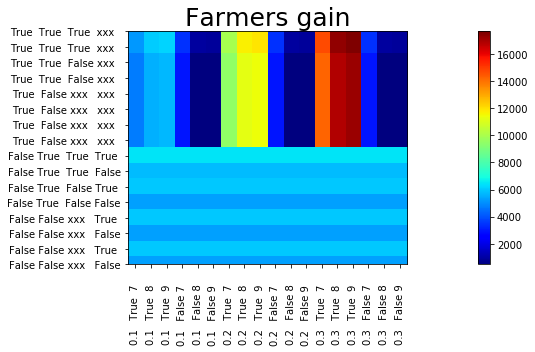

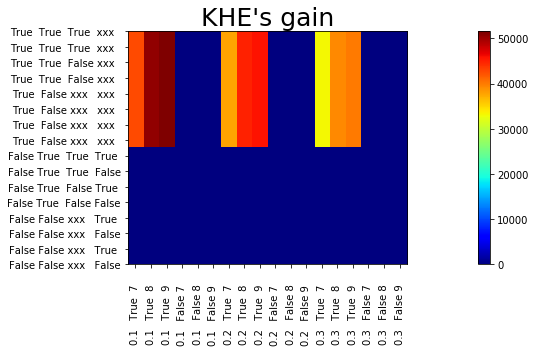

In [24]:
plt.figure(figsize=(20, 5))
plt.imshow(rev_array[0, :, :], cmap = 'jet')
plt.yticks(range(16), [' '.join(x) for x in scen_f])
plt.xticks(range(18), [' '.join(x) for x in scen_k], rotation=90)
plt.colorbar()
# plt.scatter(0, 8, c = 'k' , s = 200, marker='x')
# plt.scatter(3, 0, c = 'k' , s = 200, marker='x')
# plt.scatter(13, 0, c = 'r' , s = 200, marker='x')
# plt.scatter(23, 0, c = 'r' , s = 200, marker='x')
# plt.scatter(33, 0, c = 'r' , s = 200, marker='x')
# plt.scatter(43, 0, c = 'r' , s = 200, marker='x')
plt.title("Farmers gain", fontsize = 25)
plt.tight_layout()
plt.savefig('farmer.png', dpi=300)
plt.show()

plt.figure(figsize=(20, 5))
plt.imshow(rev_array[1, :, :], cmap = 'jet')
plt.yticks(range(16), [' '.join(x) for x in scen_f])
plt.xticks(range(18), [' '.join(x) for x in scen_k], rotation=90)
plt.colorbar()
# plt.scatter(0, 8, c = 'k' , s = 200, marker='x')
# plt.scatter(3, 0, c = 'k' , s = 200, marker='x')
# plt.scatter(13, 0, c = 'r' , s = 200, marker='x')
# plt.scatter(23, 0, c = 'r' , s = 200, marker='x')
# plt.scatter(33, 0, c = 'r' , s = 200, marker='x')
# plt.scatter(43, 0, c = 'r' , s = 200, marker='x')
plt.title("Distributor's gain", fontsize = 25)
plt.tight_layout()
plt.savefig('distributor.png', dpi=300)
plt.show()